In [2]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('data/fraud_oracle_processed.csv')

In [4]:
df.head()

,Unnamed: 0,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,WeekOfMonthClaimed,Sex,Age,...,AddressChange_Claim,NumberOfCars,Year,BasePolicy,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widow,MonthClaimed,UnusualDeductible,ClaimsPerAgent
0,0,Dec,5,Wednesday,Honda,Urban,Tuesday,1,0,21,...,2,3,1994,Liability,False,True,False,1,0,15179
1,1,Jan,3,Wednesday,Honda,Urban,Monday,4,1,34,...,0,1,1994,Collision,False,True,False,1,0,15179
2,2,Oct,5,Friday,Honda,Urban,Thursday,2,1,47,...,0,1,1994,Collision,True,False,False,11,0,15179
3,3,Jun,2,Saturday,Toyota,Rural,Friday,1,1,65,...,0,1,1994,Liability,True,False,False,7,0,15179
4,4,Jan,5,Monday,Honda,Urban,Tuesday,2,0,27,...,0,1,1994,Collision,False,True,False,2,0,15179


## Touch up on data cleaning for Feature Importance Ranking


In [5]:
# Remove index column
df = df.iloc[:, 1:]

In [6]:
# Remove one row with DayOfWeekClaimed = 0 and MonthClaimed = 0
df = df.loc[~((df['DayOfWeekClaimed'] == '0') | (df['MonthClaimed'] == '0'))]

In [7]:
# Reorder the columns such that PolicyNumber is first
cols = df.columns.tolist()         # get the current column order
cols.remove('PolicyNumber')         # remove 'PolicyNumber' from its current position
df = df[['PolicyNumber'] + cols]     # reassemble the DataFrame with 'PolicyNumber' as the first column
print("Columns:")
for col in cols:
    print(f"• {col}")   #list of labels

Columns:
• Month
• WeekOfMonth
• DayOfWeek
• Make
• AccidentArea
• DayOfWeekClaimed
• WeekOfMonthClaimed
• Sex
• Age
• Fault
• PolicyType
• VehicleCategory
• VehiclePrice
• FraudFound_P
• RepNumber
• Deductible
• DriverRating
• Days_Policy_Accident
• Days_Policy_Claim
• PastNumberOfClaims
• AgeOfVehicle
• AgeOfPolicyHolder
• PoliceReportFiled
• WitnessPresent
• AgentType
• NumberOfSuppliments
• AddressChange_Claim
• NumberOfCars
• Year
• BasePolicy
• MaritalStatus_Married
• MaritalStatus_Single
• MaritalStatus_Widow
• MonthClaimed
• UnusualDeductible
• ClaimsPerAgent


In [8]:
# Convert dummy variables to a single MaritalStatus column
df['MaritalStatus'] = df.filter(regex = '^MaritalStatus_').idxmax(axis = 1)
df['MaritalStatus'] = df['MaritalStatus'].str.replace('MaritalStatus_', '')
df.drop(['MaritalStatus_Married', 'MaritalStatus_Single', 'MaritalStatus_Widow'], axis = 1, inplace = True)

In [9]:
# Mappings for numerical df

month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

day_mapping = {
    'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7
}

area_mapping = {
    'Rural': 0, 'Urban': 1
}

fault_mapping = {
    'Policy Holder': 0, 'Third Party': 1
}

vtype_mapping = {
    'Sedan': 1, 'Sport': 2, 'Utility': 3
}

basepol_mapping = {
    'Collision': 1, 'Liability': 2, 'All Perils': 3
}

ptype_mapping = {}
for vtype, v_val in vtype_mapping.items():
    for basepol, bp_val in basepol_mapping.items():
        key = f'{vtype} - {basepol}'
        ptype_mapping[key] = v_val * 10 + bp_val

mstatus_mapping = {
    'Single': 0, 'Married': 1, 'Widow': 2
}

extra_mappings = {
    'Month': month_mapping,
    'DayOfWeek': day_mapping,
    'DayOfWeekClaimed': day_mapping,
    'AccidentArea': area_mapping,
    'Fault': fault_mapping,
    'VehicleCategory': vtype_mapping,
    'BasePolicy': basepol_mapping,
    'PolicyType': ptype_mapping,
    'MaritalStatus': mstatus_mapping
}

In [10]:
# Convert categorical variables to numerical in numeric df
numeric_df = df.copy()
for col, mapping in extra_mappings.items():
    numeric_df[col] = numeric_df[col].map(mapping)

#print(numeric_df)

In [11]:
# Remove Make(car brand) column as VehiclePrice provides more/same value as car brand and car brand is categorical
numeric_df.drop(['Make'], axis = 1, inplace = True)

In [12]:
# Create a column called DaysBetween to get the number of days between accident and claim 
# Assumption: all record in this dataset are within the same year
# Compute a rough day-of-year approximation for accident and claim dates.
numeric_df['accident_day'] = (numeric_df['Month'] - 1) * 30 + (numeric_df['WeekOfMonth'] - 1) * 7 + numeric_df['DayOfWeek']
numeric_df['claim_day'] = (numeric_df['MonthClaimed'] - 1) * 30 + (numeric_df['WeekOfMonthClaimed'] - 1) * 7 + numeric_df['DayOfWeekClaimed']
numeric_df['DaysBetween'] = numeric_df['claim_day'] - numeric_df['accident_day'] 
numeric_df['DaysBetween'] = numeric_df['DaysBetween'] + 365
numeric_df.drop(['accident_day', 'claim_day'], axis = 1, inplace = True)

print(numeric_df['DaysBetween'])
numeric_df[numeric_df['DaysBetween'] > 0]

0          6
1        370
2        373
3        387
4        375
        ... 
15415    369
15416    368
15417    368
15418    375
15419    373
Name: DaysBetween, Length: 15419, dtype: int64


,PolicyNumber,Month,WeekOfMonth,DayOfWeek,AccidentArea,DayOfWeekClaimed,WeekOfMonthClaimed,Sex,Age,Fault,...,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy,MonthClaimed,UnusualDeductible,ClaimsPerAgent,MaritalStatus,DaysBetween
0,1,12,5,3,1,2,1,0,21,0,...,0,2,3,1994,2,1,0,15179,0,6
1,2,1,3,3,1,1,4,1,34,0,...,0,0,1,1994,1,1,0,15179,0,370
2,3,10,5,5,1,4,2,1,47,0,...,0,0,1,1994,1,11,0,15179,1,373
3,4,6,2,6,0,5,1,1,65,1,...,5,0,1,1994,2,7,0,15179,1,387
4,5,1,5,1,1,2,2,0,27,1,...,0,0,1,1994,1,2,0,15179,0,375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15415,15416,11,4,5,1,2,5,1,35,0,...,0,0,1,1996,1,11,0,15179,1,369
15416,15417,11,5,4,1,5,1,1,30,0,...,5,0,3,1996,2,12,0,15179,1,368
15417,15418,11,5,4,0,5,1,1,24,0,...,1,0,1,1996,1,12,0,15179,0,368
15418,15419,12,1,1,1,4,2,0,34,1,...,5,0,1,1996,3,12,0,15179,1,375


From our exploration of the data, we realise that the max difference in claim date and accident date is 363, so we add 365 days to remove all the negative data. BIG ASSUMPTION

In [13]:
#very weird cause got some negative (can help me take a look lol)
#i mean if 12 to 1 then maybe is following year but some is like same month and week but day claimed is before day accident idk
min_negative_value = numeric_df['DaysBetween'][numeric_df['DaysBetween'] < 0].min()
print(min_negative_value)

nan


In [14]:
# Reordering columns for easier visualization
cols = numeric_df.columns.tolist()         
cols.remove("MonthClaimed")   
cols.remove("WeekOfMonthClaimed")
idx = cols.index("DayOfWeekClaimed")
cols.insert(idx, "WeekOfMonthClaimed") 
cols.insert(idx, "MonthClaimed") 
numeric_df = numeric_df[cols]

In [15]:
# Now all values are numeric and ready for RandomForrest
all_numeric = all(np.issubdtype(dtype, np.number) for dtype in numeric_df.dtypes)
print(all_numeric)

True


## Overview of value counts

In [16]:
for col in numeric_df.columns:
    print(f"Value counts for {col}:")
    print(numeric_df[col].value_counts())
    print("\n")

Value counts for PolicyNumber:
PolicyNumber
1        1
10361    1
10273    1
10274    1
10275    1
        ..
5146     1
5147     1
5148     1
5149     1
15420    1
Name: count, Length: 15419, dtype: int64


Value counts for Month:
Month
1     1411
5     1367
3     1360
6     1321
10    1305
12    1285
4     1280
2     1266
7     1256
9     1240
11    1201
8     1127
Name: count, dtype: int64


Value counts for WeekOfMonth:
WeekOfMonth
3    3640
2    3557
4    3398
1    3187
5    1637
Name: count, dtype: int64


Value counts for DayOfWeek:
DayOfWeek
1    2615
5    2445
2    2300
4    2173
3    2159
6    1982
7    1745
Name: count, dtype: int64


Value counts for AccidentArea:
AccidentArea
1    13822
0     1597
Name: count, dtype: int64


Value counts for MonthClaimed:
MonthClaimed
1     1446
5     1411
3     1348
10    1339
6     1293
2     1287
11    1285
4     1271
9     1242
7     1225
12    1146
8     1126
Name: count, dtype: int64


Value counts for WeekOfMonthClaimed:
WeekOfMonth

## Variables correlation heatmap

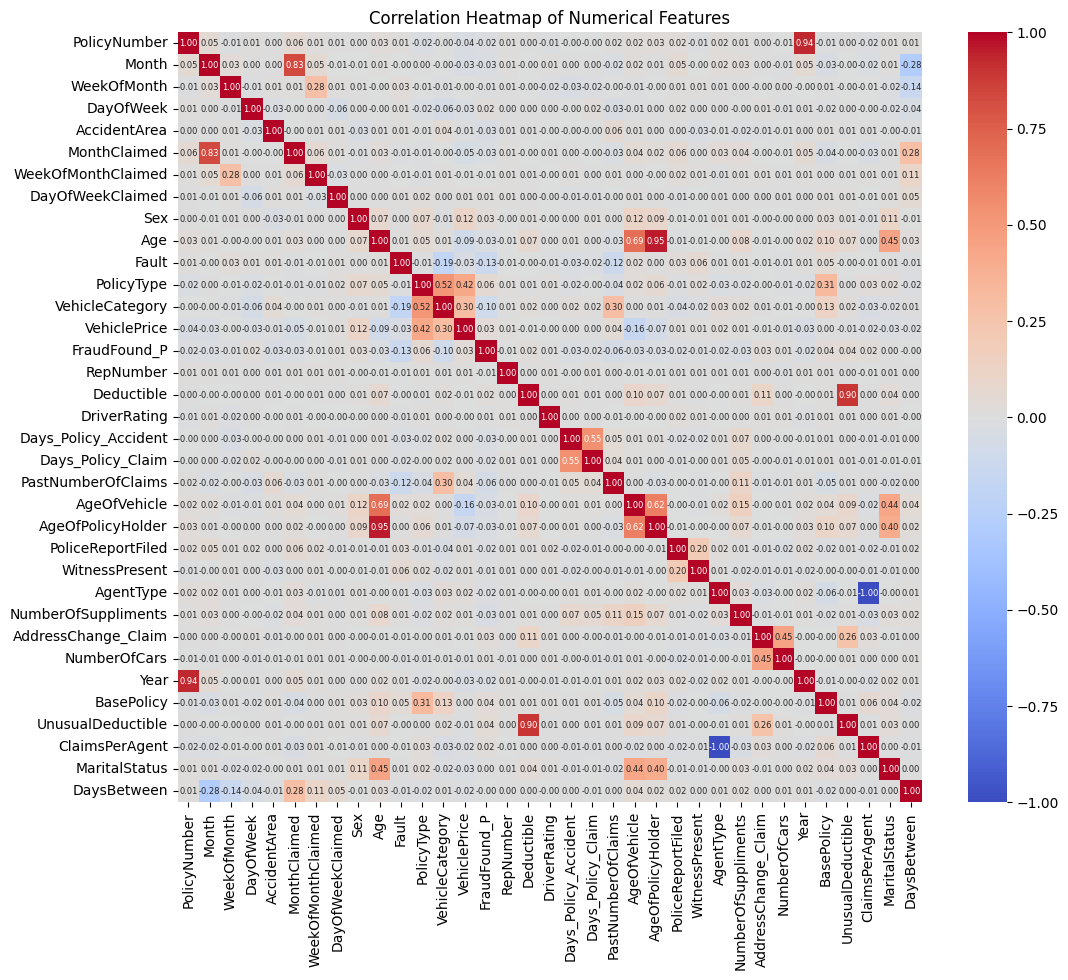

In [32]:
# Correlation heatmap
corr = numeric_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f",annot_kws={"size": 6})
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

# **Issue: Curse of Dimensionality**

The "curse of dimensionality" refers to the challenges that arise when working with high-dimensional data such as increased computational complexity and difficulty in visualization and interpretation.

Since our features contain both categorical and numerical data, we have applied several techniques to make the data more compatible. For numerical data which are far apart, we will normalize the data to ensure that they have similar ranges. For categorical data, we use label encoding to encode the categorical data into numerical values.

Hence, by ploting a histogram we can determine if our data is currently facing issue by examining the shape and the standard deviation of the plot.


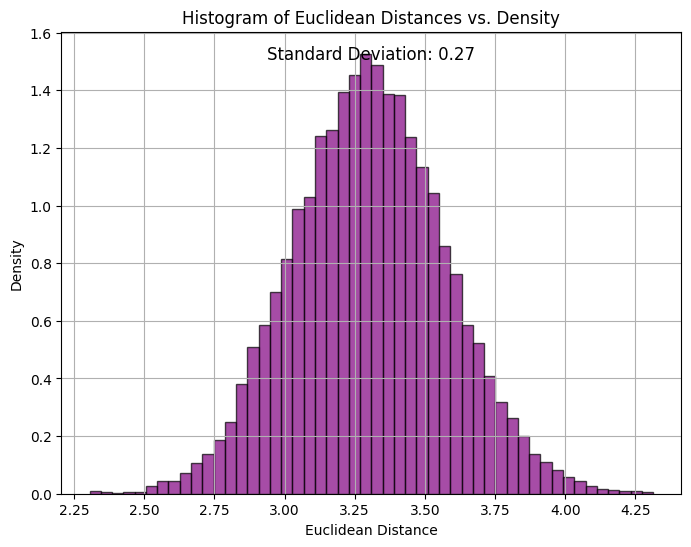

In [33]:
from sklearn.preprocessing import MinMaxScaler

# Drop the columns you don't need
X = numeric_df.drop(['FraudFound_P', 'PolicyNumber'], axis=1)

# Normalize the data (scaling between 0 and 1)
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Compute Euclidean distances between samples and origin
distances = np.linalg.norm(X_normalized, axis=1)

# Calculate standard deviation of Euclidean distances
std_dev = np.std(distances)

# Plot histogram with density
plt.figure(figsize=(8, 6))
plt.hist(distances, bins=50, density=True, edgecolor='black', alpha=0.7, color='purple')
plt.title('Histogram of Euclidean Distances vs. Density')
plt.xlabel('Euclidean Distance')
plt.ylabel('Density')
plt.grid(True)

# Add standard deviation to the plot
plt.text(0.5, 0.95, f'Standard Deviation: {std_dev:.2f}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12)

plt.show()


The plot suggests a normally distributed curve with a rounded peak and an acceptable level of standard deviation. Thus, it appears that the features excluding FraudFound_P does not exhibit the **'Curse of Dimensionality.'** Nonetheless, we intend to proceed with feature selection as we suspect the presence of some meaningless or redundant features in the dataset.

# **Identifying Significant Variables**

## Convert non-numerical data into numerical
For our feature selection, we use **Random Forest** and **XGBoost**

> Aim:

 1. `Improve Model performance by reducing the risk of overfitting`
 2. `Increase training speed by reducing computational costs`
 3. `Remove redundant features that are not meaningful to us`
 4. `Simplify our model to enhance model interpretibility`


 Note: Random Forest and XGBoost give rise to 2 different sets of top 5 features. Might have to do more analysis and determine which is better or more conclusive



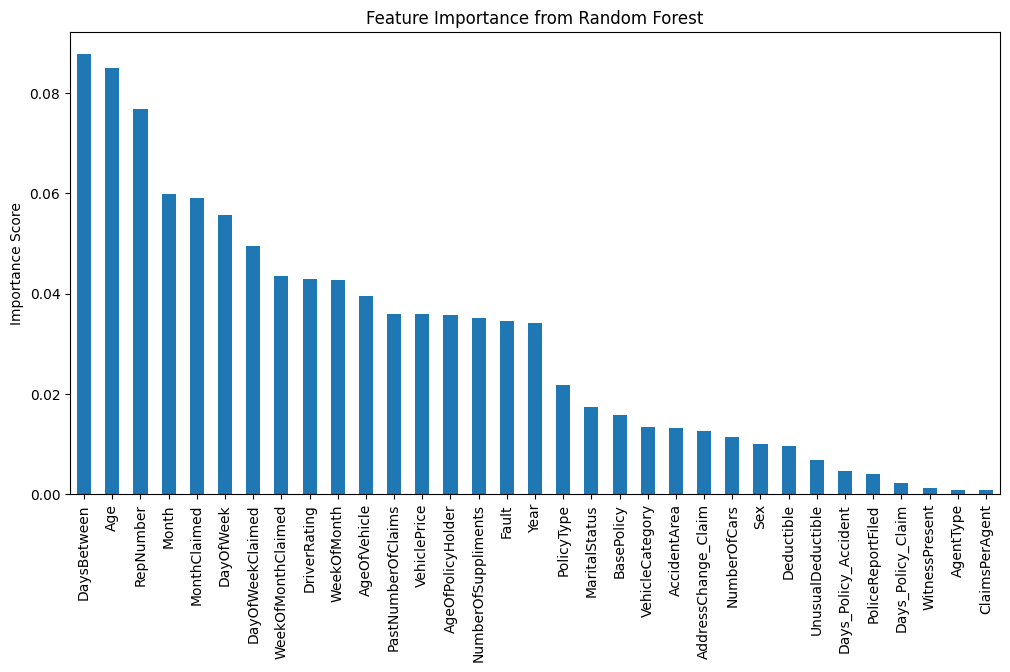

Top 5 Feature Importance Scores: 
DaysBetween     0.087751
Age             0.085010
RepNumber       0.076868
Month           0.059900
MonthClaimed    0.059032
dtype: float64


In [34]:
from sklearn.ensemble import RandomForestClassifier

X = numeric_df.drop(['FraudFound_P', 'PolicyNumber'], axis=1)
y = numeric_df['FraudFound_P']

rf = RandomForestClassifier(random_state=123)
rf.fit(X, y)
importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
importance.plot(kind='bar')
plt.title("Feature Importance from Random Forest")
plt.ylabel("Importance Score")
plt.show()
print(f"Top 5 Feature Importance Scores: \n{importance.head(5)}")

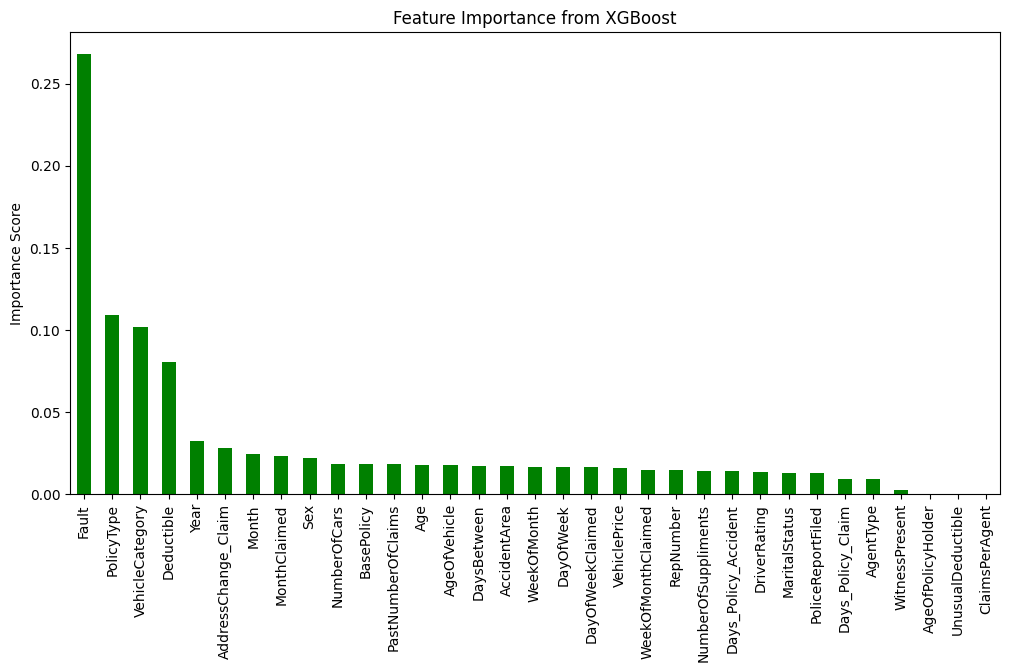

Top 5 Feature Importance Scores: 
Fault              0.267983
PolicyType         0.108991
VehicleCategory    0.101920
Deductible         0.080710
Year               0.032584
dtype: float32


In [20]:

import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt

# Prepare the data
X = numeric_df.drop(['FraudFound_P', 'PolicyNumber'], axis=1)
y = numeric_df['FraudFound_P']

# Train the XGBoost model
model = xgb.XGBClassifier(random_state=123)
model.fit(X, y)

# Get feature importance
importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot the feature importance scores
plt.figure(figsize=(12, 6))
importance.plot(kind='bar', color='green')
plt.title("Feature Importance from XGBoost")
plt.ylabel("Importance Score")
plt.show()

print(f"Top 5 Feature Importance Scores: \n{importance.head(5)}")



## EDA Visualisation (Top few important features)

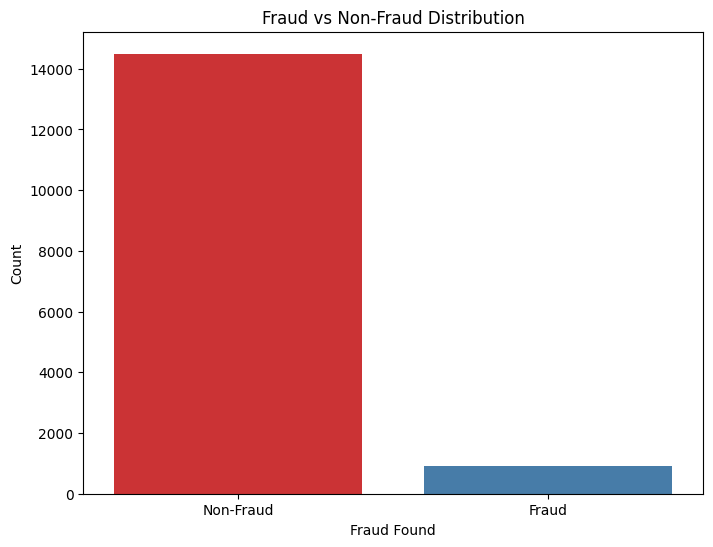

FraudFound_P
0    14496
1      923
Name: count, dtype: int64


In [35]:
# Prepare the data
fraud_vs_non_fraud = numeric_df['FraudFound_P'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(8,6))
sns.countplot(x='FraudFound_P', data=numeric_df, palette='Set1')

# Customize the plot
plt.title('Fraud vs Non-Fraud Distribution')
plt.xlabel('Fraud Found')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])

# Show the plot
plt.show()
print(fraud_vs_non_fraud)

From above, we can see that the data is very imbalanced when it comes to fraud vs non-fraud

c:\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


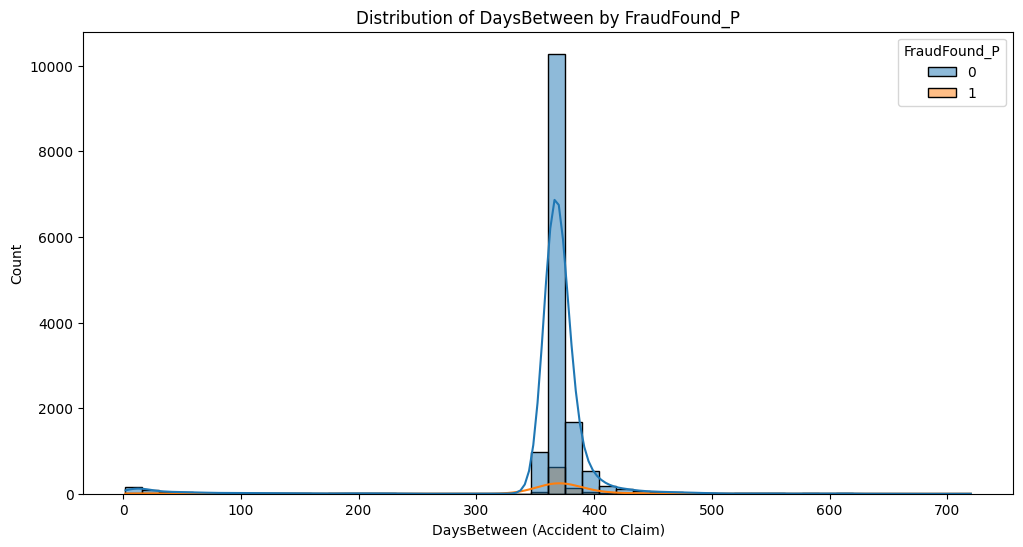

In [36]:
# Days Between
plt.figure(figsize=(12,6))
sns.histplot(data=numeric_df, x='DaysBetween', hue='FraudFound_P', bins=50, kde=True)
plt.title('Distribution of DaysBetween by FraudFound_P')
plt.xlabel('DaysBetween (Accident to Claim)')
plt.ylabel('Count')
plt.show()

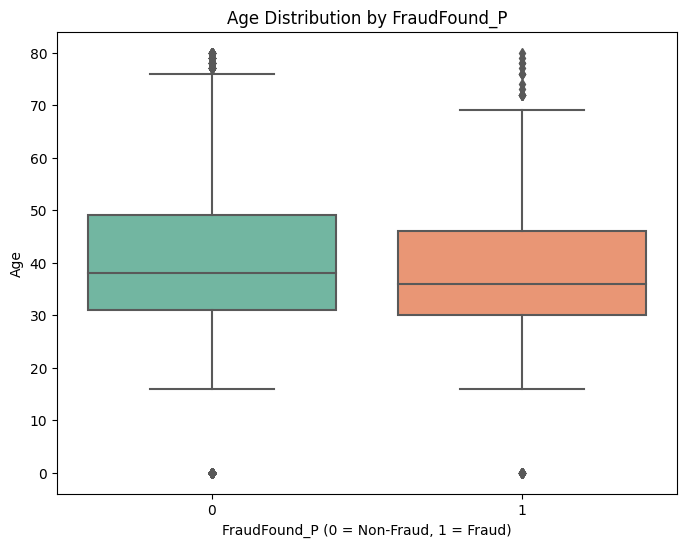

In [23]:
# Age
plt.figure(figsize=(8,6))
sns.boxplot(x='FraudFound_P', y='Age', data=numeric_df, palette='Set2')
plt.title('Age Distribution by FraudFound_P')
plt.xlabel('FraudFound_P (0 = Non-Fraud, 1 = Fraud)')
plt.ylabel('Age')
plt.show()

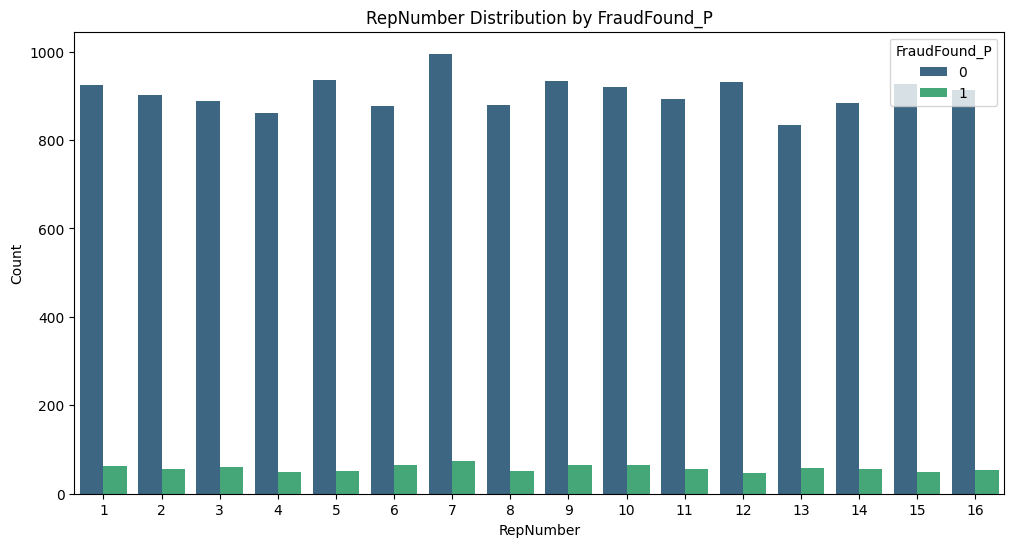

In [24]:
#RepNumber
plt.figure(figsize=(12,6))
sns.countplot(x='RepNumber', hue='FraudFound_P', data=df, palette='viridis')
plt.title('RepNumber Distribution by FraudFound_P')
plt.xlabel('RepNumber')
plt.ylabel('Count')
plt.show()

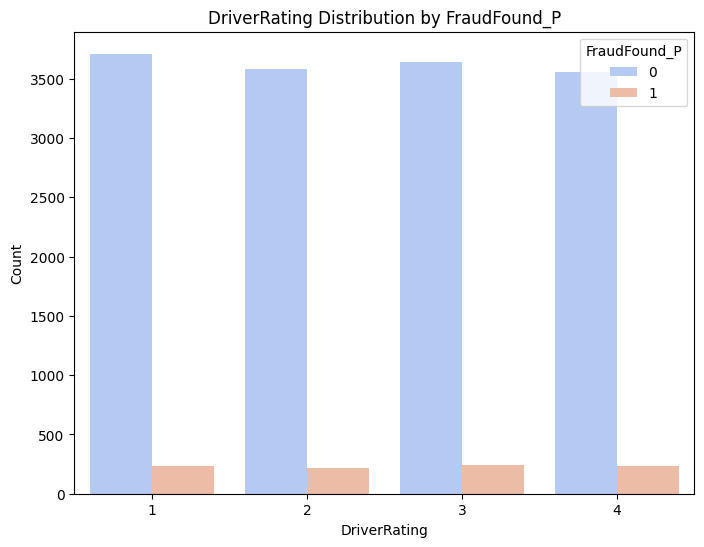

In [25]:
# Driver Rating
plt.figure(figsize=(8,6))
sns.countplot(x='DriverRating', hue='FraudFound_P', data=df, palette='coolwarm')
plt.title('DriverRating Distribution by FraudFound_P')
plt.xlabel('DriverRating')
plt.ylabel('Count')
plt.show()


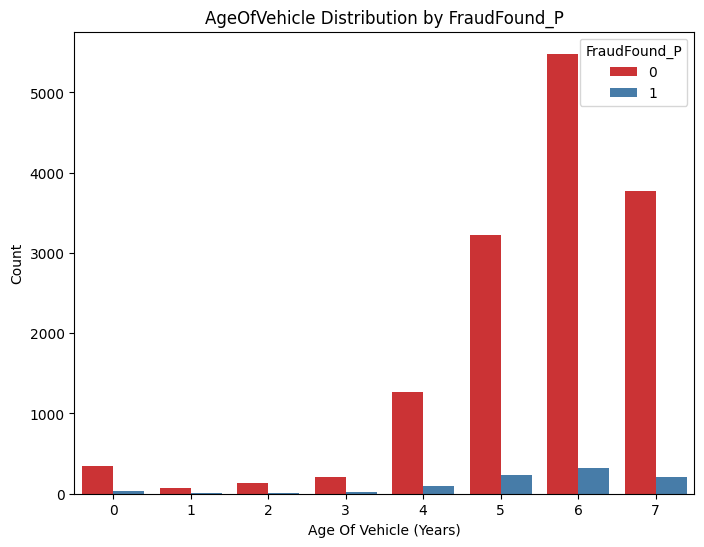

In [26]:
# AgeOfVehicle
plt.figure(figsize=(8,6))
sns.countplot(x='AgeOfVehicle', hue='FraudFound_P', data=df, palette='Set1')
plt.title('AgeOfVehicle Distribution by FraudFound_P')
plt.xlabel('Age Of Vehicle (Years)')
plt.ylabel('Count')
plt.show()

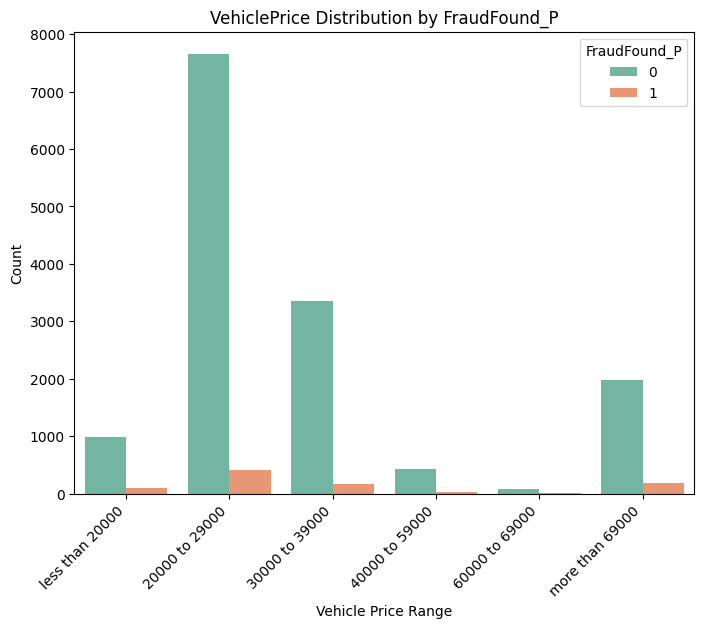

In [27]:
# VehiclePrice
plt.figure(figsize=(8,6))
g = sns.countplot(x='VehiclePrice', hue='FraudFound_P', data=numeric_df, palette='Set2')
plt.title('VehiclePrice Distribution by FraudFound_P')
plt.xlabel('Vehicle Price Range')
plt.ylabel('Count')
g.set_xticklabels(['less than 20000', '20000 to 29000', '30000 to 39000', '40000 to 59000', '60000 to 69000', 'more than 69000'], rotation=45, ha='right')
plt.show()

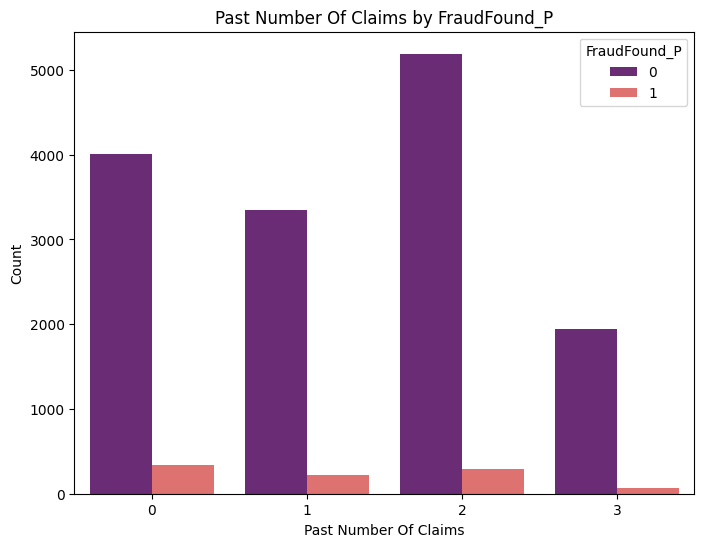

In [28]:
# Past number of claims
plt.figure(figsize=(8,6))
sns.countplot(x='PastNumberOfClaims', hue='FraudFound_P', data=numeric_df, palette='magma')
plt.title('Past Number Of Claims by FraudFound_P')
plt.xlabel('Past Number Of Claims')
plt.ylabel('Count')
plt.show()

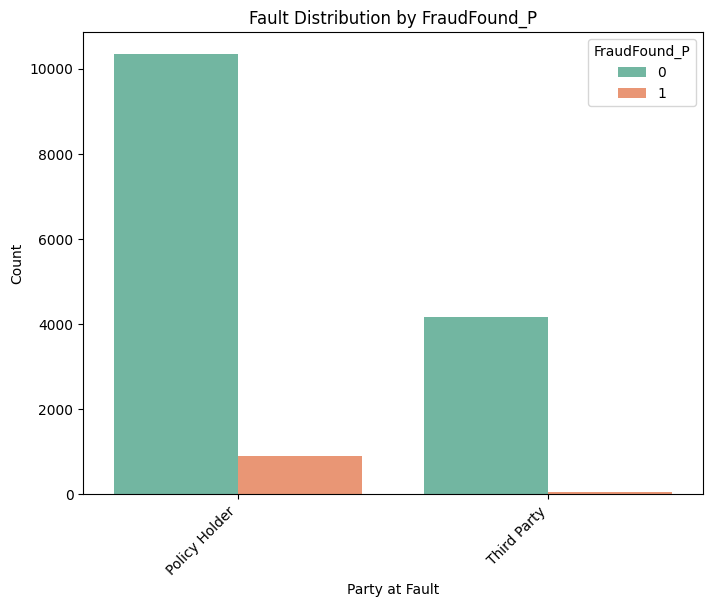

In [29]:
# Fault
plt.figure(figsize=(8,6))
g = sns.countplot(x='Fault', hue='FraudFound_P', data=numeric_df, palette='Set2')
plt.title('Fault Distribution by FraudFound_P')
plt.xlabel('Party at Fault')
plt.ylabel('Count')
g.set_xticklabels(['Policy Holder', 'Third Party'], rotation=45, ha='right')
plt.show()

# Sampling methods

### Oversampling
Use X_train_oversampled, y_train_oversampled when doing the models

In [37]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Prepare the data
X = numeric_df.drop(['FraudFound_P', 'PolicyNumber'], axis=1)
y = numeric_df['FraudFound_P']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 80-20 split

# Define SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data to oversample the minority class 
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

# Check the class distribution after oversampling
print("Class distribution after oversampling:")
print(pd.Series(y_train_oversampled).value_counts().to_string())




Class distribution after oversampling:
FraudFound_P
1    11611
0    11611


In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
# from imblearn.over_sampling import SMOTE

In [39]:
# Train logistic regression model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_oversampled, y_train_oversampled)

# Predictions
y_pred_lr = lr_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_lr)
conf_matrix = confusion_matrix(y_test, y_pred_lr)
classification_rep = classification_report(y_test, y_pred_lr)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_rep)


Accuracy: 0.7124
Confusion Matrix:
[[2109  776]
 [ 111   88]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.73      0.83      2885
           1       0.10      0.44      0.17       199

    accuracy                           0.71      3084
   macro avg       0.53      0.59      0.50      3084
weighted avg       0.90      0.71      0.78      3084



C:\Users\harry\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [40]:
rf_model = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=36)
rf_model.fit(X_train_oversampled, y_train_oversampled)
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print("==== Random Forest ====")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

==== Random Forest ====
Accuracy: 0.8920
Confusion Matrix:
[[2716  169]
 [ 164   35]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      2885
           1       0.17      0.18      0.17       199

    accuracy                           0.89      3084
   macro avg       0.56      0.56      0.56      3084
weighted avg       0.89      0.89      0.89      3084



In [41]:
xgb_model = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_model.fit(X_train_oversampled, y_train_oversampled)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluation
print("==== XGBoost ====")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))

c:\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:27:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


==== XGBoost ====
Accuracy: 0.8878
Confusion Matrix:
[[2690  195]
 [ 151   48]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      2885
           1       0.20      0.24      0.22       199

    accuracy                           0.89      3084
   macro avg       0.57      0.59      0.58      3084
weighted avg       0.90      0.89      0.89      3084



In [42]:
lgb_model = lgb.LGBMClassifier(n_estimators=100, random_state=42)
lgb_model.fit(X_train_oversampled, y_train_oversampled)
y_pred_lgb = lgb_model.predict(X_test)

# Evaluation
print("==== LightGBM ====")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lgb):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lgb))
print("Classification Report:")
print(classification_report(y_test, y_pred_lgb))

[LightGBM] [Info] Number of positive: 11611, number of negative: 11611
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 563
[LightGBM] [Info] Number of data points in the train set: 23222, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
==== LightGBM ====
Accuracy: 0.8628
Confusion Matrix:
[[2600  285]
 [ 138   61]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92      2885
           1       0.18      0.31      0.22       199

    accuracy                           0.86      3084
   macro avg       0.56      0.60      0.57      3084
weighted avg       0.90      0.86      0.88      3084



### Undersampling
Use X_train_under, y_train_under when doing the models

In [31]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

# Prepare the data
X = numeric_df.drop(['FraudFound_P', 'PolicyNumber'], axis=1)
y = numeric_df['FraudFound_P']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80-20 split

# Define RandomUnderSampler
under_sampler = RandomUnderSampler(random_state=42)

# Apply RandomUnderSampler to the training data to reduce the majority class size
X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)

# Check the class distribution after undersampling
print("Class distribution after undersampling:")
print(pd.Series(y_train_under).value_counts().to_string())



Class distribution after undersampling:
FraudFound_P
0    724
1    724
